# Test Técnico - Inteligencia Artificial

**Mostrar algunos ejemplos del dataset**

In [15]:
img_train = 'train/train-images-idx3-ubyte'
lbs_train = 'train/train-labels-idx1-ubyte'
img_test = 'test/t10k-images-idx3-ubyte'
lbs_test = 'test/t10k-labels-idx1-ubyte'

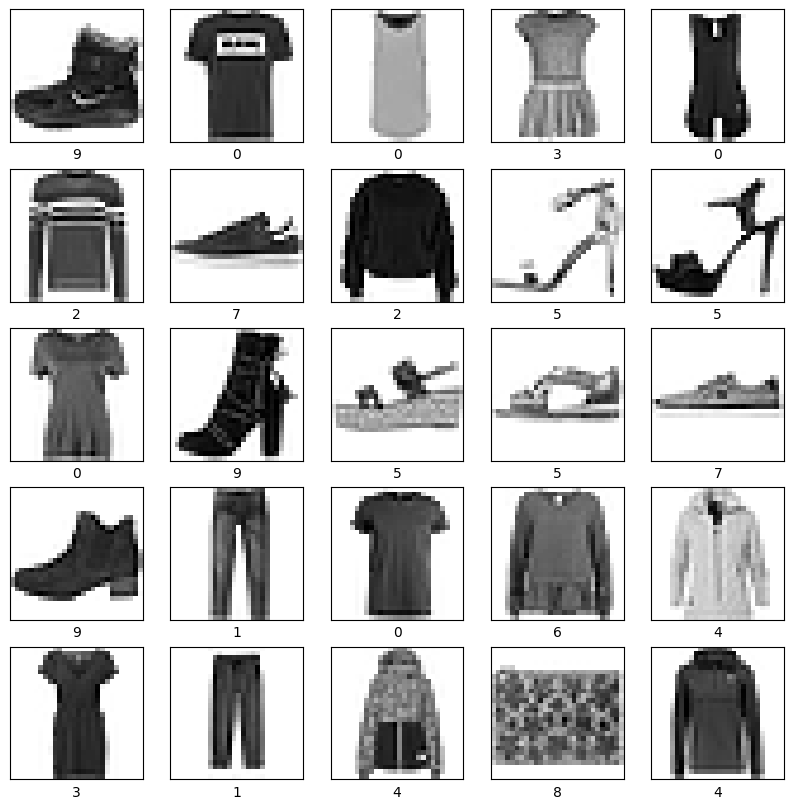

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Funciones para leer archivos IDX
def read_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = np.frombuffer(f.read(16), dtype=np.uint32).byteswap()
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
    return data

def read_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_items = np.frombuffer(f.read(8), dtype=np.uint32).byteswap()
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels


# Cargar datos desde los archivos
train_img = read_images(img_train)
train_lbs = read_labels(lbs_train)
test_img = read_images(img_test)
test_lbs = read_labels(lbs_test)


# Visualizar las imágenes
plt.figure(figsize=(10, 10))
for i in range(25):  # Mostrar las primeras 25 imágenes
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_img[i], cmap=plt.cm.binary)  # Mostrar imagen
    plt.xlabel(train_lbs[i])  # Mostrar etiqueta correspondiente
plt.show()


**Tamaño de las imágenes y etiquetas**

In [22]:
print("Train images shape:", train_img.shape)
print("Train labels shape:", train_lbs.shape)
print("Test images shape:", test_img.shape)
print("Test labels shape:", test_lbs.shape)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


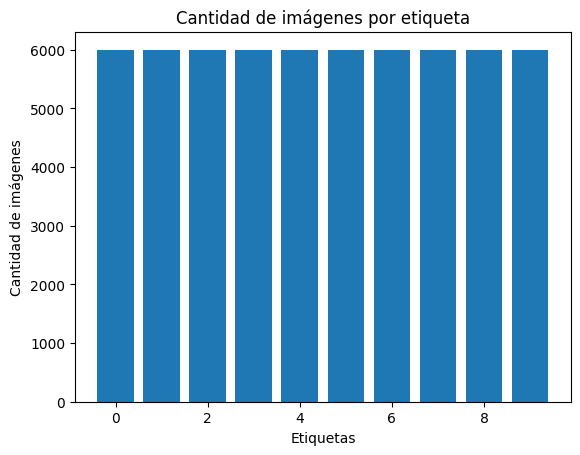

In [23]:
import pandas as pd
import seaborn as sns

def plot_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(ydf[0], order = np.arange(0,10))
    g.set_title("Number of items for each class")
    g.set_xlabel("Category")
    
    for p, label in zip(g.patches, np.arange(0,10)):
        g.annotate(train_lbs[label], (p.get_x(), p.get_height()+0.1))
        
    plt.show()  

def get_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    # Get the count for each label
    label_counts = ydf[0].value_counts()

    # Get total number of samples
    total_samples = len(yd)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = train_lbs[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))
    
plot_count_per_class(np.argmax(train_lbs,axis=1))
get_count_per_class(np.argmax(train_lbs,axis=1))


Distribución de etiquetas de los datos de entrenamiento equilibrada, cada prenda de vestir tiene 6000 imágenes de entrenamiento y 1000 imágenes de prueba. Las imágenes son de 28x28 pixeles en escala de grises, con valores de pixel entre 0 y 255. Las etiquetas son enteros entre 0 y 9, correspondientes a las siguientes clases:

Con el objetivo de mejorar la precisión de la clasificación, normalizaremos los valores de los pixeles de las imágenes para que estén en el rango [0, 1]. Esto ayudará a que el modelo converja más rápido.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from seaborn import heatmap
from tensorflow.keras.optimizers import Adam
import csv
from sklearn.metrics import classification_report


class ModeloBase:
    def __init__(self, nombre):
        self.nombre = nombre
        self.modelo = None

    def cargar_datos(self):
        # Implementar la carga de datos
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
        return (X_train, y_train), (X_test, y_test)
    
    def read_images(self, filename):
        with open(filename, 'rb') as f:
            magic, num_images, rows, cols = np.frombuffer(f.read(16), dtype=np.uint32).byteswap()
            data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
        return data

    def read_labels(self, filename):
        with open(filename, 'rb') as f:
            magic, num_items = np.frombuffer(f.read(8), dtype=np.uint32).byteswap()
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

    def preprocesamiento(self, x, y, classes=10, n=28):
        # Normalizar las imágenes y convertir las etiquetas a one-hot encoding
        x = np.reshape(x, (-1, n, n, 1))
        x = x.astype('float32') / 255.0
        y = to_categorical(y, classes)
        return x, y
    
    def splitData(self, X, y):
        # Dividir los datos utilizando train_test_split
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
        # Convertir los arreglos de NumPy a tensores de TensorFlow
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
        y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
    
        return X_train, X_val, y_train, y_val

    def compile(self, lr):
        # Implementar la compilación del modelo
        self.modelo.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    def entrenar(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        # Entrenar el modelo con datos de validación
        history = self.modelo.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val)
        )
        return history

    def entrenar_final(self, X_train, y_train, epochs, batch_size):
        # Entrenar el modelo sin datos de validación
        history = self.modelo.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size
        )
        return history

    def evaluar(self, X_test, y_test):
        # Implementar la evaluación del modelo
        self.modelo.evaluate(X_test, y_test)
        return self.modelo.evaluate(X_test, y_test)
    
    def guardar(self):
        # Implementar el guardado del modelo
        self.modelo.save(f'modelos/{self.nombre}.h5')

    def forward(self, x):
        return self.modelo(x, training=False)
    
    def predict(self, X):
        if self.modelo is None:
            raise ValueError("El modelo no está definido.")
        if not hasattr(self.modelo, 'predict'):
            raise AttributeError("El modelo no tiene el método 'predict'.")
        
        # Genera predicciones
        predicciones = self.modelo.predict(X)
        return predicciones


    def plot_training_history(self, history):
        # Obtener datos del historial de entrenamiento
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(acc) + 1)

        # Graficar la precisión
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'b', label='Precisión en entrenamiento')
        plt.plot(epochs, val_acc, 'r', label='Precisión en validación')
        plt.title('Precisión en entrenamiento y validación')
        plt.xlabel('Épocas')
        plt.ylabel('Precisión')
        plt.legend()
        
        # Graficar la pérdida
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'b', label='Pérdida en entrenamiento')
        plt.plot(epochs, val_loss, 'r', label='Pérdida en validación')
        plt.title('Pérdida en entrenamiento y validación')
        plt.xlabel('Épocas')
        plt.ylabel('Pérdida')
        plt.legend()

        plt.show()

    def confusion_matrix(self, X_test, y_test):
        # Implementar la matriz de confusión con seaborn
        y_pred = self.modelo.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_test = np.argmax(y_test, axis=1)
        cm = tf.math.confusion_matrix(y_test, y_pred)
        heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicción')
        plt.ylabel('Real')
        plt.show()

    def guardar_predicciones(self, predicciones, nombre_archivo):
        # Convertir las probabilidades en etiquetas de clase (número del 0 al 9)
        etiquetas = np.argmax(predicciones, axis=1)
        # Guardar las etiquetas en un archivo CSV
        with open(nombre_archivo, mode='w', newline='') as archivo:
            escritor_csv = csv.writer(archivo)
            escritor_csv.writerow(['id', 'label'])  # Encabezados del CSV
            for idx, etiqueta in enumerate(etiquetas, start=60001):  # Empezar el ID en 60001
                escritor_csv.writerow([idx, etiqueta])

    def clasification_report(self, X_test, y_test):
        # Implementar el reporte de clasificación
        y_pred = self.modelo.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_test = np.argmax(y_test, axis=1)
        print(classification_report(y_test, y_pred))

In [3]:
class CNNModel(ModeloBase):
    def __init__(self):
        super().__init__('CNN')
        self.modelo = self.definir_modelo()
        
    def definir_modelo(self):
    # Definir la arquitectura del modelo CNN
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
        return model

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models

class LetNetModel(ModeloBase):
    def __init__(self):
        super().__init__('LeNet')
        self.modelo = self.definir_modelo()

    def definir_modelo(self):
        # Definir la arquitectura del modelo LeNet-5 adaptada a imágenes de 28x28x1
        model = models.Sequential([
            layers.Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(28, 28, 1)),
            layers.AveragePooling2D(pool_size=(2, 2)),
            layers.Conv2D(16, kernel_size=(5, 5), activation='tanh'),
            layers.AveragePooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(120, activation='tanh'),
            layers.Dense(84, activation='tanh'),
            layers.Dense(10, activation='softmax')
        ])
        return model

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models

class CNNDeepModel(ModeloBase):
    def __init__(self):
        super().__init__('CNNDeep')
        self.modelo = self.definir_modelo()
        
    def definir_modelo(self):
        model = models.Sequential([
            # Primera capa de convolución
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            # Segunda capa de convolución
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            # Tercera capa de convolución
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            # Aplanamiento y capas densas
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(10, activation='softmax')
        ])
        return model

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models

class CNN2(ModeloBase):
    def __init__(self):
        super().__init__('CNN2')
        self.modelo = self.definir_modelo()
        
    def definir_modelo(self):
        model = models.Sequential([
            # Primera capa de convolución
            layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(10, activation='softmax')        
        ])
        return model

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

class CNN3(ModeloBase):
    def __init__(self):
        super().__init__('CNN3')
        self.modelo = self.definir_modelo()
        
    def definir_modelo(self):
        # Definir la arquitectura del modelo CNN
        model = tf.keras.models.Sequential([
            # Primera capa convolucional
            layers.Conv2D(32, kernel_size=3, padding="same", activation=None, input_shape=(28, 28, 1)),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=2, strides=2),
            
            # Segunda capa convolucional
            layers.Conv2D(64, kernel_size=3, activation=None),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=2),
            
            # Aplanar y capas densas
            layers.Flatten(),
            layers.Dense(600, activation='relu'),
            layers.Dropout(0.25),  # Dropout para regularización
            layers.Dense(120, activation='relu'),
            layers.Dense(10, activation='softmax')  # 10 clases para clasificación
        ])
        return model


Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6591 - loss: 0.9969 - val_accuracy: 0.7923 - val_loss: 0.5444
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8145 - loss: 0.5128 - val_accuracy: 0.8255 - val_loss: 0.4717
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8371 - loss: 0.4492 - val_accuracy: 0.8373 - val_loss: 0.4362
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8543 - loss: 0.4085 - val_accuracy: 0.8545 - val_loss: 0.3966
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8620 - loss: 0.3788 - val_accuracy: 0.8533 - val_loss: 0.3894
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8520 - loss: 0.4076
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8520 - loss: 0.4076
Pérdida en el conjunto de prueba: 0.4154
Precisión en el conjunto de prueba: 0.8480


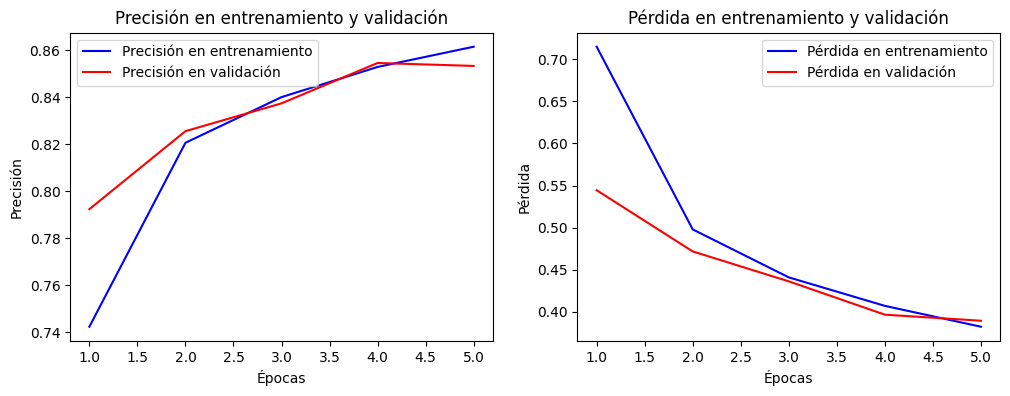

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [74]:
# LetNet
letnet = LetNetModel()    # instanciar modelo LeNet
X_train = letnet.read_images(img_train)
y_train = letnet.read_labels(lbs_train)
X_test = letnet.read_images(img_test)
y_test = letnet.read_labels(lbs_test)
X_train, y_train = letnet.preprocesamiento(X_train, y_train)   # preprocesamiento train
X_test, y_test = letnet.preprocesamiento(X_test, y_test)       # preprocesamiento test
X_train, X_val, y_train, y_val = letnet.splitData(X_train, y_train)   # dividir datos de entrenamiento 
letnet.compile(lr=0.0005)   # compilar modelo
history = letnet.entrenar(X_train, y_train, X_val, y_val, epochs=5, batch_size=64)   # entrenar modelo
loss, accuracy = letnet.evaluar(X_test, y_test)    # evaluar modelo

print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

# graficos de presicion y perdida
letnet.plot_training_history(history)

predicciones = letnet.predict(X_test)
letnet.guardar_predicciones(predicciones, 'predicciones/letnet_predicts.csv')

# guardar modelo
letnet.guardar()   

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.4067 - loss: 1.9761 - val_accuracy: 0.7429 - val_loss: 0.6815
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6859 - loss: 0.9273 - val_accuracy: 0.7827 - val_loss: 0.5830
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.7212 - loss: 0.7807 - val_accuracy: 0.8077 - val_loss: 0.5238
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.7503 - loss: 0.6950 - val_accuracy: 0.8202 - val_loss: 0.4871
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.7683 - loss: 0.6500 - val_accuracy: 0.8295 - val_loss: 0.4622
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.7894 - loss: 0.5865 - val_accuracy: 0.8387 - val_loss: 0.4315
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7988 - loss: 0.5621 - val_accuracy: 0.8403 - val_loss: 0.4185
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8080 - loss: 0.5274 - 

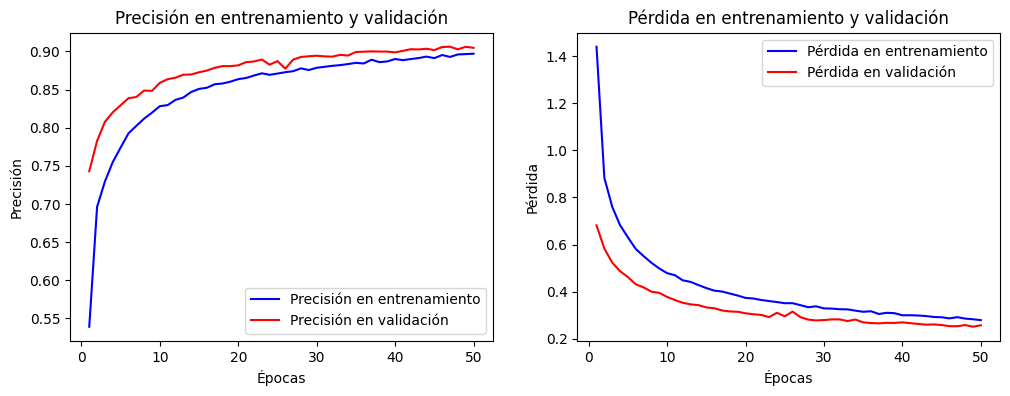

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [8]:
cnn = CNNDeepModel()    # instanciar modelo CNN
X_train = cnn.read_images(img_train)
y_train = cnn.read_labels(lbs_train)
X_test = cnn.read_images(img_test)
y_test = cnn.read_labels(lbs_test)
X_train, y_train = cnn.preprocesamiento(X_train, y_train)   # preprocesamiento train
X_test, y_test = cnn.preprocesamiento(X_test, y_test)       # preprocesamiento test
X_train, X_val, y_train, y_val = cnn.splitData(X_train, y_train)   # dividir datos de entrenamiento 
cnn.compile(lr=0.0001)   # compilar modelo
history = cnn.entrenar(X_train, y_train, X_val, y_val, epochs=50, batch_size=64)   # entrenar modelo
loss, accuracy = cnn.evaluar(X_test, y_test)    # evaluar modelo

print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

# graficos de presicion y perdida
cnn.plot_training_history(history)

predicciones = cnn.predict(X_test)
cnn.guardar_predicciones(predicciones, 'predicciones/cnnDeep_predicts.csv')

# guardar modelo
cnn.guardar()   

/Users/achula/miniconda3/envs/IA_PAP/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6553 - loss: 1.0092 - val_accuracy: 0.8077 - val_loss: 0.5156
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8214 - loss: 0.4933 - val_accuracy: 0.8354 - val_loss: 0.4366
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8481 - loss: 0.4185 - val_accuracy: 0.8572 - val_loss: 0.3906
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8653 - loss: 0.3764 - val_accuracy: 0.8668 - val_loss: 0.3630
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8763 - loss: 0.3449 - val_accuracy: 0.8792 - val_loss: 0.3332
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8828 - loss: 0.3289 - val_accuracy: 0.8841 - val_loss: 0.3219
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8900 - loss: 0.3050 - val_accuracy: 0.8884 - val_loss: 0.3090
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8955 - loss: 0.2909 - val

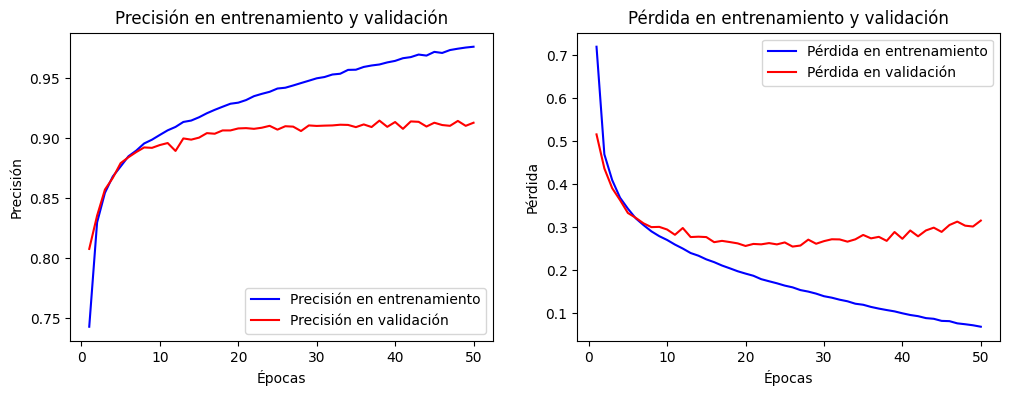

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [26]:
cnn2 = CNN2()    # instanciar modelo CNN
X_train = cnn2.read_images(img_train)
y_train = cnn2.read_labels(lbs_train)
X_test = cnn2.read_images(img_test)
y_test = cnn2.read_labels(lbs_test)
X_train, y_train = cnn2.preprocesamiento(X_train, y_train)   # preprocesamiento train
X_test, y_test = cnn2.preprocesamiento(X_test, y_test)       # preprocesamiento test
X_train, X_val, y_train, y_val = cnn2.splitData(X_train, y_train)   # dividir datos de entrenamiento 
cnn2.compile(lr=0.0001)   # compilar modelo
history = cnn2.entrenar(X_train, y_train, X_val, y_val, epochs=50, batch_size=64)   # entrenar modelo
loss, accuracy = cnn2.evaluar(X_test, y_test)    # evaluar modelo

print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

# graficos de presicion y perdida
cnn2.plot_training_history(history)

predicciones = cnn2.predict(X_test)
cnn2.guardar_predicciones(predicciones, 'predicciones/cnn2_predicts.csv')

# guardar modelo
cnn2.guardar()   

/Users/achula/miniconda3/envs/IA_PAP/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7456 - loss: 0.7244 - val_accuracy: 0.8593 - val_loss: 0.3733
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8767 - loss: 0.3428 - val_accuracy: 0.8839 - val_loss: 0.3131
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8926 - loss: 0.2931 - val_accuracy: 0.8982 - val_loss: 0.2790
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9077 - loss: 0.2536 - val_accuracy: 0.8974 - val_loss: 0.2789
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.9156 - loss: 0.2315 - val_accuracy: 0.9048 - val_loss: 0.2568
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9209 - loss: 0.2142 - val_accuracy: 0.9094 - val_loss: 0.2458
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9324 - loss: 0.1851 - val_accuracy: 0.9091 - val_loss: 0.2515
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.9357 - loss: 0.1752 - 

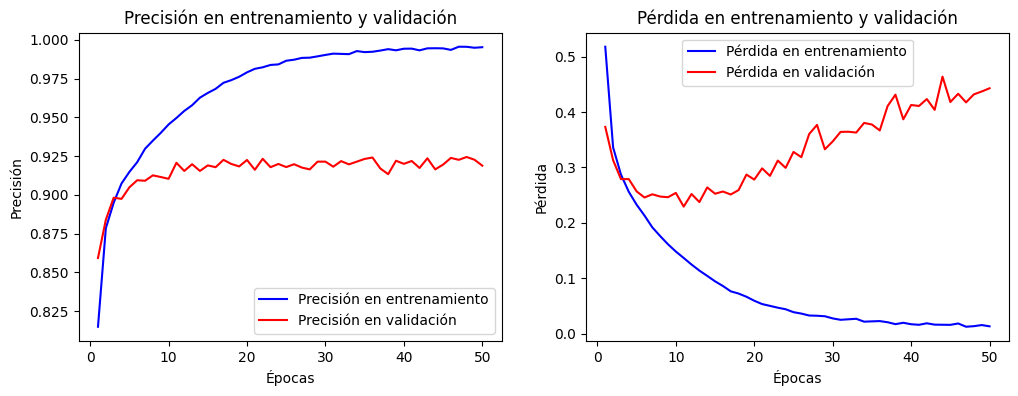

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [37]:
cnn3 = CNN3()    # instanciar modelo CNN
X_train = cnn3.read_images(img_train)
y_train = cnn3.read_labels(lbs_train)
X_test = cnn3.read_images(img_test)
y_test = cnn3.read_labels(lbs_test)
X_train, y_train = cnn3.preprocesamiento(X_train, y_train)   # preprocesamiento train
X_test, y_test = cnn3.preprocesamiento(X_test, y_test)       # preprocesamiento test
X_train, X_val, y_train, y_val = cnn3.splitData(X_train, y_train)   # dividir datos de entrenamiento 
cnn3.compile(lr=0.0001)   # compilar modelo
history = cnn3.entrenar(X_train, y_train, X_val, y_val, epochs=50, batch_size=64)   # entrenar modelo
loss, accuracy = cnn3.evaluar(X_test, y_test)    # evaluar modelo

print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

# graficos de presicion y perdida
cnn3.plot_training_history(history)

predicciones = cnn3.predict(X_test)
cnn3.guardar_predicciones(predicciones, 'predicciones/cnn3_predicts.csv')

# guardar modelo
cnn3.guardar()   

**El modelo con mejores resultado lo entreno con todos los datos de entrenamiento y validación, y luego lo evalúo con los datos de prueba:**

In [ ]:
cnn3_final = CNN3()    # instanciar modelo CNN
X_train = cnn3_final.read_images(img_train)
y_train = cnn3_final.read_labels(lbs_train)
X_test = cnn3_final.read_images(img_test)
y_test = cnn3_final.read_labels(lbs_test)
X_train, y_train = cnn3_final.preprocesamiento(X_train, y_train)   # preprocesamiento train
X_test, y_test = cnn3_final.preprocesamiento(X_test, y_test)       # preprocesamiento test
cnn3_final.compile(lr=0.001)   # compilar modelo
history = cnn3_final.entrenar_final(X_train, y_train, epochs=50, batch_size=64)   # entrenar modelo
loss, accuracy = cnn3_final.evaluar(X_test, y_test)    # evaluar modelo

print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

# graficos de presicion y perdida
# cnn2_final.plot_training_history(history)

predicciones = cnn3_final.predict(X_test)
cnn3_final.guardar_predicciones(predicciones, 'predicciones/cnn3_final_predicts.csv')

# guardar modelo
cnn2_final.guardar()   

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.7632 - loss: 0.6657
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.8794 - loss: 0.3308
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.8970 - loss: 0.2825
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9107 - loss: 0.2466
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.9187 - loss: 0.2208
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9260 - loss: 0.2034
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9326 - loss: 0.1855
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.9360 - loss: 0.1721
Epoch 9/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9399 - loss: 0.1606
Epoch 10/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.9418 - loss: 0.1548
Epoch 11/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9496 - loss: 0.1379
Epoch 12/50
938/938 ━━━━━━━━━━

In [40]:
cnn3.clasification_report(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1000
           1       1.00      0.97      0.98      1000
           2       0.87      0.88      0.87      1000
           3       0.88      0.94      0.91      1000
           4       0.91      0.81      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.71      0.82      0.76      1000
           7       0.95      0.98      0.96      1000
           8       0.99      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000

